In [1]:
import itertools
import warnings
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
warnings.filterwarnings('ignore')


In [5]:
df = pd.read_csv("/Users/mustafaemircan/PycharmProjects/MiuulBootcamp/Time Series/airline-passengers.csv", index_col="month", parse_dates=True)

In [7]:
df.head(10)

,total_passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


In [8]:
df.shape

(144, 1)

In [9]:
df.isnull().sum()

total_passengers    0
dtype: int64

In [10]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='month', length=144, freq=None)

**index bilgisinde freq None olarak gözükmekte. bunu düzeltiyoruz. buraya aylık bilgisi giriyoruz. "MS" olarak.**


In [11]:
df.index.freq = "MS"

# TEST - TRAIN

In [13]:
train = df[:120]
test = df[120:]

In [19]:
train.tail()

,total_passengers
month,
1958-08-01,505
1958-09-01,404
1958-10-01,359
1958-11-01,310
1958-12-01,337


In [18]:
test.head()

,total_passengers
month,
1959-01-01,360
1959-02-01,342
1959-03-01,406
1959-04-01,396
1959-05-01,420


In [27]:
test.shape

(24, 1)

# DICKEY - FULLER TEST

In [20]:
def is_stationary(y):

    # "HO: Non-stationary"  # durağan değil
    # "H1: Stationary"      # durağan

    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        print(F"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        print(F"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")

In [21]:
is_stationary(df)

Result: Non-Stationary (H0: non-stationary, p-value: 0.992)


In [22]:
def ts_decompose(y, model="additive", stationary=False):
    result = seasonal_decompose(y, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

    if stationary:
        is_stationary(y)

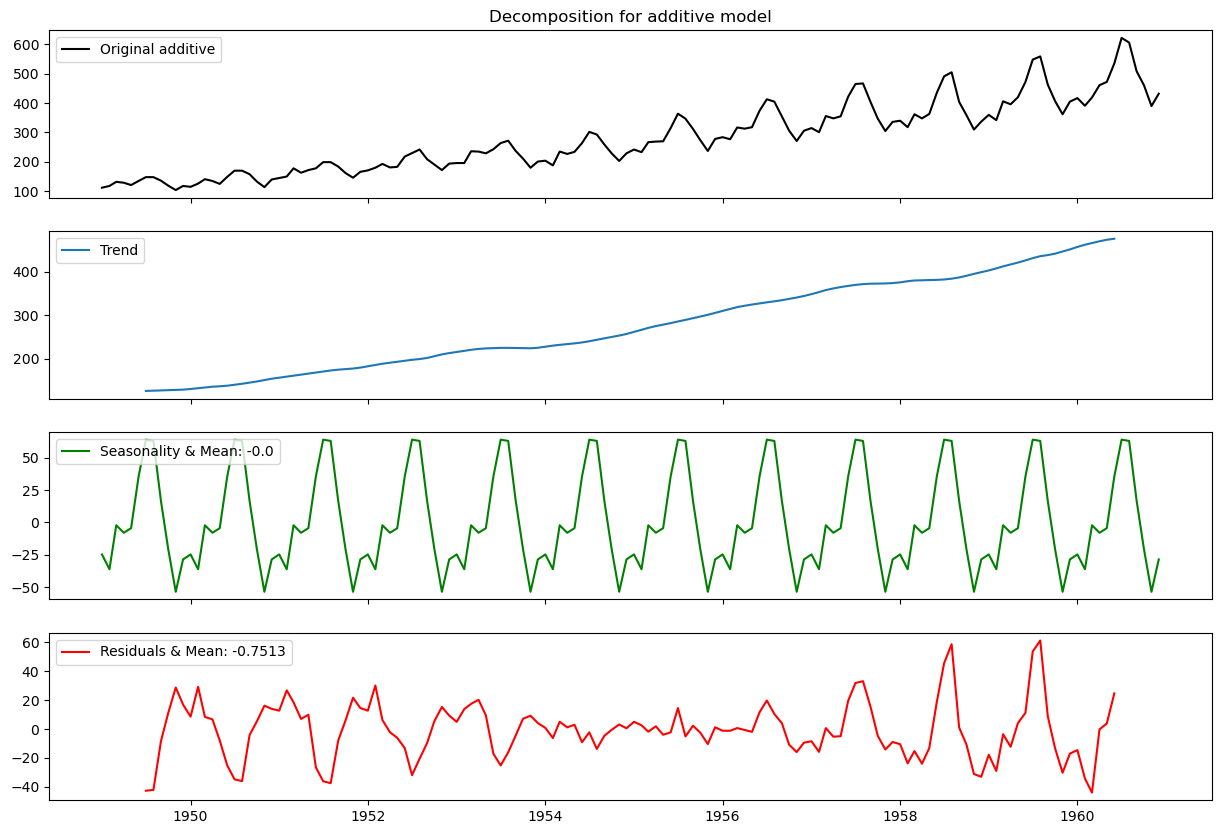

Result: Non-Stationary (H0: non-stationary, p-value: 0.992)


In [23]:
ts_decompose(df, stationary=True)

# SES

In [24]:
def ses_optimizer(train, alphas, step=48):
    best_alpha, best_mae = None, float("inf")
    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_mae = alpha, mae
        print("alpha:", round(alpha, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae

In [25]:
alphas = np.arange(0.01, 1, 0.10)

In [26]:
alphas

array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91])

In [28]:
best_alpha, best_mae = ses_optimizer(train, alphas, step=24)

alpha: 0.01 mae: 225.5863
alpha: 0.11 mae: 82.528
alpha: 0.21 mae: 82.8979
alpha: 0.31 mae: 89.8377
alpha: 0.41 mae: 99.0585
alpha: 0.51 mae: 107.5558
alpha: 0.61 mae: 113.7514
alpha: 0.71 mae: 117.2224
alpha: 0.81 mae: 118.1776
alpha: 0.91 mae: 117.2438
best_alpha: 0.11 best_mae: 82.528


In [29]:
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha)

In [30]:
y_pred_SES = ses_model.forecast(24)

# VISUALIZATION

In [32]:
def plot_prediction(y_pred, label):
    train["total_passengers"].plot(legend=True, label="TRAIN")
    test["total_passengers"].plot(legend=True, label="TEST")
    y_pred.plot(legend=True, label="PREDICTION")
    plt.title("Train, Test and Predicted Test Using "+label)
    plt.show()

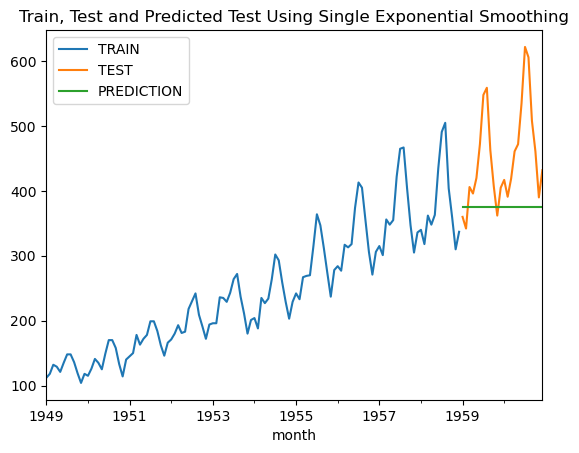

In [33]:
plot_prediction(y_pred_SES, "Single Exponential Smoothing")

# DES

In [38]:
def des_optimizer(train, alphas, betas, step=48):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
            #print("alpha:", round(alpha, 2), "beta:", round(beta, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae

In [39]:
alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)

In [40]:
best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas, step=24)

best_alpha: 0.01 best_beta: 0.11 best_mae: 54.1036


In [43]:
des_model = (ExponentialSmoothing(train, trend="add").
             fit(smoothing_level=best_alpha, smoothing_slope=best_beta))

In [44]:
y_pred_DES = des_model.forecast(24)

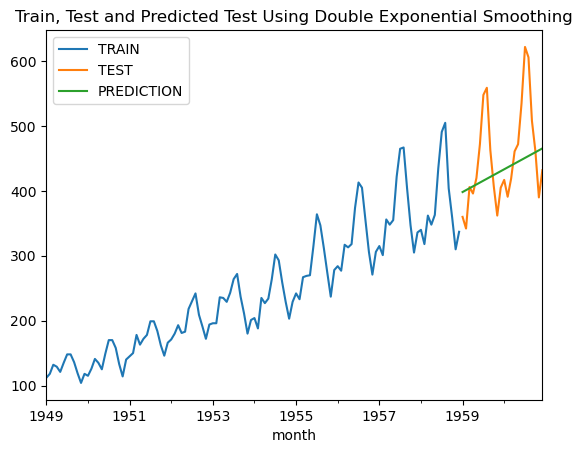

In [45]:
plot_prediction(y_pred_DES, "Double Exponential Smoothing")

# TES

In [54]:
def tes_optimizer(train, abg, step=48):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        #print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    #print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", #round(best_gamma, 2),
          #"best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae

In [55]:
alphas = betas = gammas = np.arange(0.10, 1, 0.20)
abg = list(itertools.product(alphas, betas, gammas))

In [56]:
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg, step=24)

In [65]:
print("alpha: ", best_alpha, " beta: ", best_beta, " gamma: ", best_gamma, "mae: ", best_mae)

alpha:  0.30000000000000004  beta:  0.30000000000000004  gamma:  0.5000000000000001 mae:  11.994672894260034


In [61]:
tes_model = ExponentialSmoothing(train, trend = "add", seasonal = "add", seasonal_periods = 12).fit(smoothing_level = best_alpha, smoothing_slope = best_beta, smoothing_seasonal = best_gamma)

In [62]:
y_pred_TES = tes_model.forecast(24)

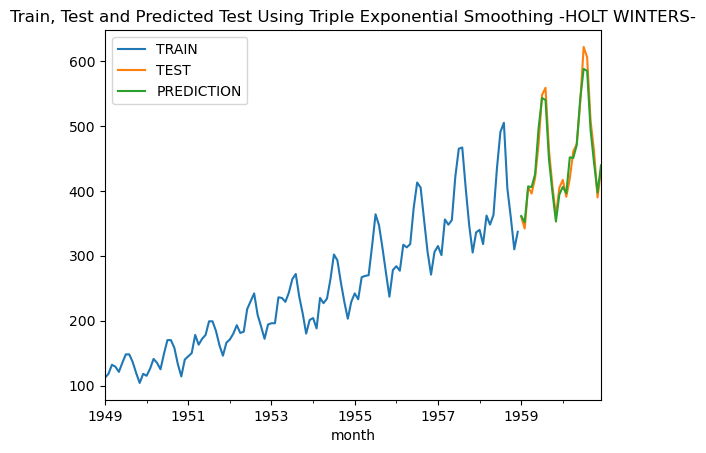

In [63]:
plot_prediction(y_pred_TES, "Triple Exponential Smoothing -HOLT WINTERS-")

In [64]:
mean_absolute_error(test, y_pred_TES)

11.994672894260034

# ARIMA (p, d, q)
**Autoregressive Integrated Moving Average**

In [66]:
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))

In [70]:
def arima_optimizer_aic(train, orders):
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arima_model = sm.tsa.ARIMA(train, order=order).fit()
            aic = arima_model.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
            #print('ARIMA%s AIC=%.2f' % (order, aic))
        except:
            continue
    print('Best ARIMA%s AIC=%.2f' % (best_params, best_aic))
    return best_params

In [71]:
best_params_aic = arima_optimizer_aic(train, pdq)

Best ARIMA(3, 1, 3) AIC=1089.76


In [72]:
arima_model = sm.tsa.ARIMA(train, order=best_params_aic).fit()

In [75]:
y_pred_ARIMA = arima_model.forecast(steps=len(test))
y_pred_ARIMA = pd.Series(y_pred_ARIMA, index=test.index)

In [76]:
y_pred_ARIMA.head()

month
1959-01-01    362.911022
1959-02-01    351.905747
1959-03-01    384.229535
1959-04-01    388.935185
1959-05-01    413.965130
Freq: MS, Name: predicted_mean, dtype: float64

In [77]:
mean_absolute_error(test, y_pred_ARIMA)

64.0121404720174

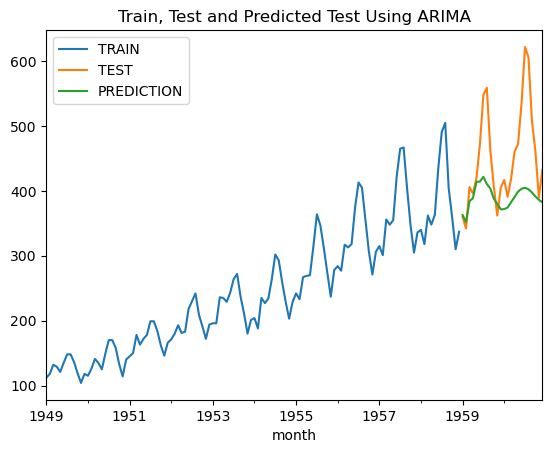

In [78]:
plot_prediction(y_pred_ARIMA, "ARIMA")

# SARIMA (p, d, q) (P, D, Q)
**Seasonal Autoregressive Integrated Moving Average**


In [79]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

In [80]:
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [85]:
def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), float("inf"), None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                results = sarimax_model.fit(disp=0)
                aic = results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
                #print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, aic))
            except:
                continue
    #print('SARIMA{}x{}12 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    return best_order, best_seasonal_order

In [86]:
best_order, best_seasonal_order = sarima_optimizer_aic(train, pdq, seasonal_pdq)

In [87]:
model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_model = model.fit(disp=0)

In [88]:
y_pred_test = sarima_model.get_forecast(steps=24)

In [89]:
y_pred_test

In [90]:
y_pred = y_pred_test.predicted_mean

In [91]:
y_pred_SARIMA = pd.Series(y_pred, index=test.index)

In [92]:
y_pred_SARIMA.head()

month
1959-01-01    341.958954
1959-02-01    319.729056
1959-03-01    363.784171
1959-04-01    349.770958
1959-05-01    364.774126
Freq: MS, Name: predicted_mean, dtype: float64

In [93]:
mean_absolute_error(test, y_pred_SARIMA)

68.57726545422953

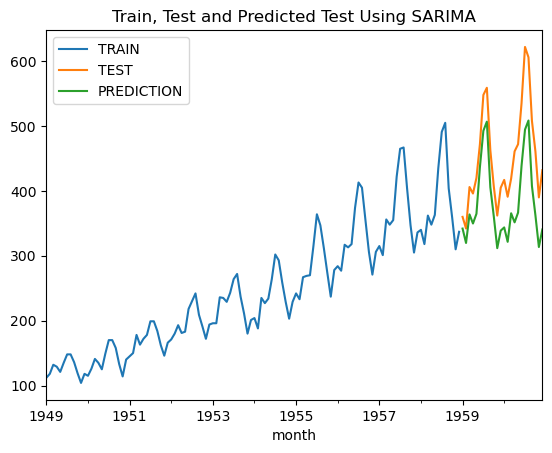

In [94]:
plot_prediction(y_pred_SARIMA, "SARIMA")

# SARIMA MODEL WITH MAE

In [95]:
def sarima_optimizer_mae(train, pdq, seasonal_pdq):
    best_mae, best_order, best_seasonal_order = float("inf"), float("inf"), None

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                sarima_model = model.fit(disp=0)
                y_pred_test = sarima_model.get_forecast(steps=24)
                y_pred = y_pred_test.predicted_mean
                mae = mean_absolute_error(test, y_pred)

                # mae = fit_model_sarima(train, val, param, param_seasonal)

                if mae < best_mae:
                    best_mae, best_order, best_seasonal_order = mae, param, param_seasonal
                #print('SARIMA{}x{}12 - MAE:{}'.format(param, param_seasonal, mae))
            except:
                continue
    #print('SARIMA{}x{}12 - MAE:{}'.format(best_order, best_seasonal_order, best_mae))
    return best_order, best_seasonal_order

In [96]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] 

In [97]:
best_order, best_seasonal_order = sarima_optimizer_mae(train, pdq, seasonal_pdq)

In [98]:
model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_model_mae = model.fit(disp=0)

In [99]:
y_pred_test = sarima_model_mae.get_forecast(steps=24)

In [100]:
y_pred_SARIMA_MAE = y_pred_test.predicted_mean

In [101]:
y_pred_SARIMA_MAE = pd.Series(y_pred_SARIMA_MAE, index=test.index)

In [102]:
y_pred_SARIMA_MAE.head()

month
1959-01-01    364.754254
1959-02-01    339.643788
1959-03-01    386.697850
1959-04-01    371.415407
1959-05-01    388.950778
Freq: MS, Name: predicted_mean, dtype: float64

In [103]:
mean_absolute_error(test, y_pred_SARIMA_MAE)

30.59854722495321

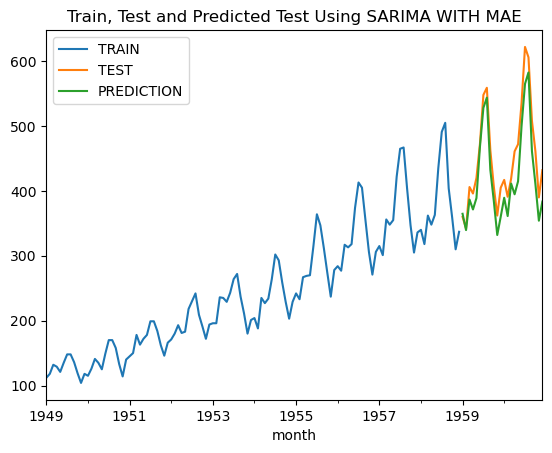

In [104]:
plot_prediction(y_pred_SARIMA_MAE, "SARIMA WITH MAE")

# BEST MODEL: TEST

**Predicting the next 12 months with the best model -TES-**

In [110]:
tes_final_model = ExponentialSmoothing(df, trend="add", seasonal="add", seasonal_periods=12).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)

In [115]:
pred_final_model = tes_final_model.forecast(steps=12)

In [116]:
pred_final_model

1961-01-01    450.286323
1961-02-01    429.302008
1961-03-01    475.721700
1961-04-01    502.017548
1961-05-01    516.825551
1961-06-01    579.037162
1961-07-01    654.463728
1961-08-01    642.031481
1961-09-01    542.324747
1961-10-01    489.166608
1961-11-01    427.230267
1961-12-01    472.829308
Freq: MS, dtype: float64

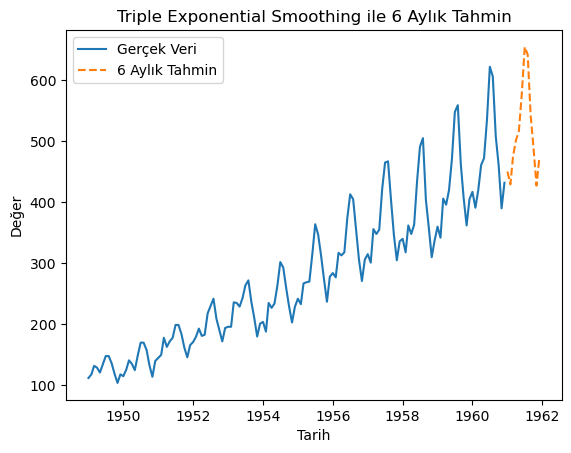

In [117]:
# Gerçek veriyi plot etmek
plt.plot(df, label="Gerçek Veri")

# Gelecek 6 ayın tahminini plot etmek
plt.plot(pred_final_model, label="6 Aylık Tahmin", linestyle='--')

# Başlık ve eksen etiketlerini ekleme
plt.title("Triple Exponential Smoothing ile 6 Aylık Tahmin")
plt.xlabel("Tarih")
plt.ylabel("Değer")
plt.legend()

# Grafiği gösterme
plt.show()

# THANKS